In [1]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

#Import Qiskit classes
from qiskit import assemble, transpile
from qiskit.providers.aer import AerSimulator
from qiskit.utils import QuantumInstance

#Import the qv function
import qiskit.ignis.verification.quantum_volume as qv

from qiskit import IBMQ
if IBMQ.active_account() is None:
    IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-kaist', group='internal', project='reservations')
backend = provider.get_backend('ibmq_toronto')
# backend = AerSimulator.from_backend(backend)

quantum_instance = QuantumInstance(backend=backend, shots=2**13, optimization_level=3)
# noinspection PyUnresolvedReferences
import qiskit.tools.jupyter

In [2]:
backend

<IBMQBackend('ibmq_toronto') from IBMQ(hub='ibm-q-kaist', group='internal', project='reservations')>

In [3]:
basis_gates = backend.configuration().basis_gates

In [4]:
# qubit_lists: list of list of qubit subsets to generate QV circuits
# full_qubit = [0, 1, 2, 3, 5, 8, 11, 14, 16]
full_qubit = [0, 1, 2, 3, 5, 8, 11, 14, 16]
qubit_lists = [full_qubit[:k] for k in range(4, 10)]
# ntrials: Number of random circuits to create for each subset
ntrials = 100

In [5]:
import warnings
warnings.filterwarnings('ignore')
qv_circs, qv_circs_nomeas = qv.qv_circuits(qubit_lists, ntrials)

In [6]:
# sv_sim = qiskit.Aer.get_backend('aer_simulator')
sv_sim = QuantumInstance(backend=AerSimulator(), shots=2**13)
ideal_results = []
for trial in tqdm(range(ntrials)):
    # clear_output(wait=True)
    for qc in qv_circs_nomeas[trial]:
        qc.save_statevector()
    #result = qiskit.execute(qv_circs_nomeas[trial], backend=sv_sim).result()
    result = sv_sim.execute(qv_circs_nomeas[trial])
    ideal_results.append(result)
    # print(f'Simulated trial {trial+1}/{ntrials}')

  0%|          | 0/100 [00:00<?, ?it/s]

In [7]:
qv_fitter = qv.QVFitter(qubit_lists=qubit_lists)
qv_fitter.add_statevectors(ideal_results)



In [8]:
%qiskit_job_watcher
exp_results = []
for trial in tqdm(range(ntrials)):
    # t_qcs = transpile(qv_circs[trial], basis_gates=basis_gates)
    # qobj = assemble(t_qcs)
    # result = backend.run(qobj, max_parallel_experiments=0, shots=2**13).result()
    result = quantum_instance.execute(qv_circs[trial])
    exp_results.append(result)

qv_fitter.add_data(exp_results)

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

  0%|          | 0/100 [00:00<?, ?it/s]

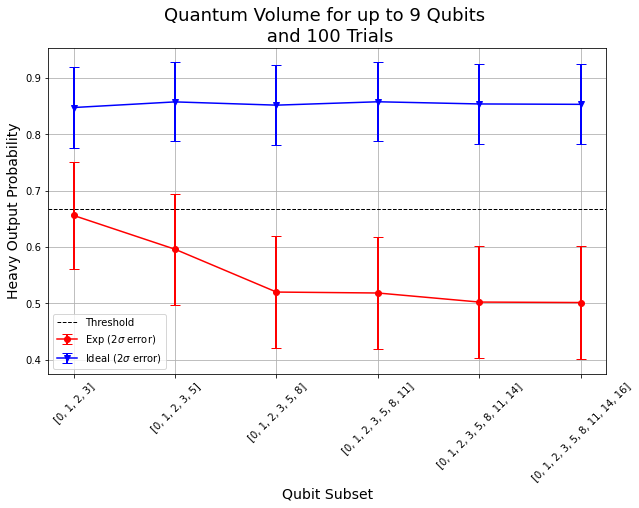

In [9]:
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot the essence by calling plot_rb_data
qv_fitter.plot_qv_data(ax=ax, show_plt=False)

# Add title and label
ax.set_title('Quantum Volume for up to %d Qubits \n and %d Trials'%(len(qubit_lists[-1]), ntrials), fontsize=18)

plt.show()

In [10]:
qv_success_list = qv_fitter.qv_success()
qv_list = qv_fitter.ydata
QV = 1
for qidx, qubit_list in enumerate(qubit_lists):
    if qv_list[0][qidx]>2/3:
        if qv_success_list[qidx][0]:
            print("Width/depth %d greater than 2/3 (%f) with confidence %f (successful). Quantum volume %d"%
                  (len(qubit_list),qv_list[0][qidx],qv_success_list[qidx][1],qv_fitter.quantum_volume()[qidx]))
            QV = qv_fitter.quantum_volume()[qidx]
        else:
            print("Width/depth %d greater than 2/3 (%f) with confidence %f (unsuccessful)."%
                  (len(qubit_list),qv_list[0][qidx],qv_success_list[qidx][1]))
    else:
        print("Width/depth %d less than 2/3 (unsuccessful)."%len(qubit_list))

Width/depth 4 less than 2/3 (unsuccessful).
Width/depth 5 less than 2/3 (unsuccessful).
Width/depth 6 less than 2/3 (unsuccessful).
Width/depth 7 less than 2/3 (unsuccessful).
Width/depth 8 less than 2/3 (unsuccessful).
Width/depth 9 less than 2/3 (unsuccessful).


In [11]:
print ("The Quantum Volume is:", QV) 

The Quantum Volume is: 1


### References

[1] Andrew W. Cross, Lev S. Bishop, Sarah Sheldon, Paul D. Nation, and Jay M. Gambetta, *Validating quantum computers using randomized model circuits*, Phys. Rev. A **100**, 032328 (2019). https://arxiv.org/pdf/1811.12926

In [12]:
time_taken = sum([result.time_taken for result in exp_results])
print('total execution time: ', time_taken, 's')

import dill
with open('./qv_fitter', 'wb') as f:
    dill.dump(qv_fitter, f)

total execution time:  3101.4567573070526 s


# Summary

In [13]:
print(f'QPU: {backend.name()}')
print(f'Execution time purly in QPU for QV: {time_taken}s')
print('QV number of qubits: ', list(map(lambda x: len(x), qubit_lists)))
print('QV success rate    : ', list(map(lambda x: str(round(100*x[1], 2))+'%', qv_success_list)))

QPU: ibmq_toronto
Execution time purly in QPU for QV: 3101.4567573070526s
QV number of qubits:  [4, 5, 6, 7, 8, 9]
QV success rate    :  ['40.97%', '7.44%', '0.16%', '0.15%', '0.05%', '0.05%']


In [14]:
%qiskit_version_table

# requested random circuit

In [15]:
from temp import random_circuit

rd_circuit = []
for qubit_list in qubit_lists:
    n = len(qubit_list)
    qc = random_circuit(n, n, measure=True)
    rd_circuit.append(qc)

with open('./random_circuits', 'wb') as f:
    dill.dump(rd_circuit, f)

In [22]:
ideal_random_circuit_result = []
for trial in tqdm(range(ntrials)):
    result = sv_sim.execute(rd_circuit)
    ideal_random_circuit_result.append(result)

  0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
%qiskit_job_watcher
random_circuit_result = []
for trial in tqdm(range(ntrials)):
    # t_qcs = transpile(rd_circuit, basis_gates=basis_gates)
    # qobj = assemble(t_qcs)
    # result = backend.run(qobj, max_parallel_experiments=0, shots=2**13).result()
    result = quantum_instance.execute(rd_circuit)
    random_circuit_result.append(result)

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

  0%|          | 0/100 [00:00<?, ?it/s]

In [17]:
for qubit_list in qubit_lists:
    n = len(qubit_list)

In [23]:
from itertools import product
ideal_data_list = []
for i, qubit_list in enumerate(qubit_lists):
    n = len(qubit_list)
    d = {}
    for sec in product('01', repeat=n):
        key = ''.join(sec)
        d[key] = []
    for trial in range(ntrials):
        result = ideal_random_circuit_result[trial]
        counts = result.get_counts(i)
        for key in d.keys():
            d[key].append(counts.get(key, 0))
    ideal_data_list.append(d)

In [24]:
from pandas import DataFrame, ExcelWriter
excel_file = ExcelWriter('./counts(ideal).xlsx')
for i, qubit_list in enumerate(qubit_lists):
    df = DataFrame(data = ideal_data_list[i], index=[f'trial {j}' for j in range(ntrials)])
    df.to_excel(excel_file, sheet_name=f'{len(qubit_list)} num qubits')

excel_file.save()

In [25]:
from itertools import product
data_list = []
for i, qubit_list in enumerate(qubit_lists):
    n = len(qubit_list)
    d = {}
    for sec in product('01', repeat=n):
        key = ''.join(sec)
        d[key] = []
    for trial in range(ntrials):
        result = random_circuit_result[trial]
        counts = result.get_counts(i)
        for key in d.keys():
            d[key].append(counts.get(key, 0))
    data_list.append(d)

In [26]:
from pandas import DataFrame, ExcelWriter
excel_file = ExcelWriter('./counts(real).xlsx')
for i, qubit_list in enumerate(qubit_lists):
    df = DataFrame(data = data_list[i], index=[f'trial {j}' for j in range(ntrials)])
    df.to_excel(excel_file, sheet_name=f'{len(qubit_list)} num qubits')

excel_file.save()

# Summary

In [20]:
time_taken = sum([r.time_taken for r in random_circuit_result])
print(f'QPU: {backend.name()}')
print(f'Execution time purly in QPU for counts: {time_taken}s')
print('circuits: saved at ./random_circuits')

QPU: ibmq_toronto
Execution time purly in QPU for counts: 2735.9472148418427s
circuits: saved at ./random_circuits
